<a href="https://colab.research.google.com/github/KShinyShamma/Activity_Recognition/blob/main/Webcam_Pose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ultralytics
import ultralytics
!pip install opencv-python
import cv2

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


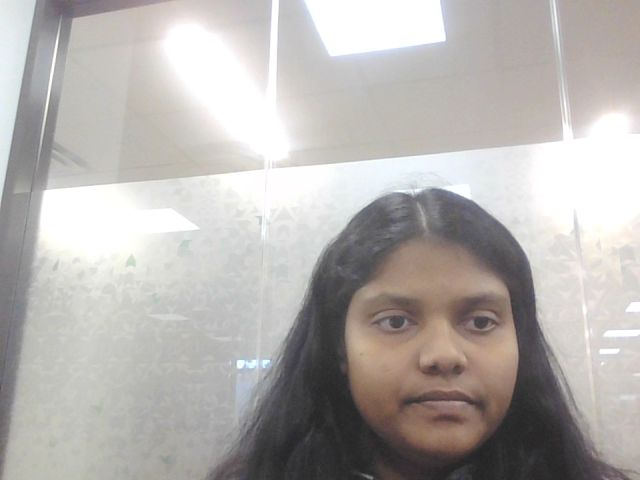

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from ultralytics import YOLO  # Make sure you have the YOLO library installed

# Load the YOLO model for pose estimation (ensure you have the correct model)
model = YOLO("yolo11n-pose.pt")

# Build the activity classification model (ensure it matches the model structure for loaded weights)
activity_model = Sequential()
activity_model.add(Dense(64, input_dim=34, activation='relu'))  # Assuming 34 keypoints (17*2 for x and y)
activity_model.add(Dense(32, activation='relu'))
activity_model.add(Dense(16, activation='relu'))
activity_model.add(Dense(4, activation='softmax'))  # Assuming 4 classes: Sitting, Laying, Jumping, Standing
activity_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Load the pre-trained model weights
activity_model.load_weights('/content/drive/MyDrive/P2/DATA/activity_model_weights.weights.h5')

# webcam capture
cap = cv2.VideoCapture(0)  # 0 for the default webcam

# To Check if the webcam is opened correctly
if not cap.isOpened():
    print("Error: Could not access the webcam.")
    exit()

# Real-time loop for live detection
while True:
    ret, frame = cap.read()
    if not ret:
        break


    results = model(frame, verbose=False)

    # Loop
    for r in results:
        bound_box = r.boxes.xyxy
        conf = r.boxes.conf.tolist()
        keypoints = r.keypoints.xyn.tolist()

        for index, box in enumerate(bound_box):
            if conf[index] > 0.75:  # Confidence threshold
                # bounding box
                x1, y1, x2, y2 = box.tolist()
                cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)

                # Extract keypoints (x, y coordinates) and convert to absolute positions
                keypoints_data = []
                for kp_index, (x, y) in enumerate(keypoints[index]):
                    # Convert normalized keypoints to pixel positions and draw them
                    cv2.circle(frame, (int(x * frame.shape[1]), int(y * frame.shape[0])), 5, (0, 255, 0), -1)
                    keypoints_data.append(x * frame.shape[1])  # x-coordinate
                    keypoints_data.append(y * frame.shape[0])  # y-coordinate

                # input data for the activity classification model
                keypoints_data = np.array(keypoints_data).reshape(1, -1)  # Reshape

                # Predict the activity
                activity_pred = activity_model.predict(keypoints_data)
                activity_label = np.argmax(activity_pred, axis=1)

                # Map the predicted activity class to a label
                activity_labels = ['Sitting', 'Laying', 'Jumping', 'Standing']
                predicted_activity = activity_labels[activity_label[0]]

                # Display the predicted activity on the frame
                cv2.putText(frame, f'Activity: {predicted_activity}', (int(x1), int(y1) - 20),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Show output frame with detection and prediction
    cv2.imshow('Real-time Activity Detection', frame)

    # Press 'q' to quit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Error: Could not access the webcam.


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Load the YOLO model for pose estimation
model = YOLO("yolo11n-pose.pt")

# Build and load the pre-trained activity classification model
activity_model = Sequential()
activity_model.add(Dense(64, input_dim=34, activation='relu'))  # Assuming 34 keypoints (17*2 for x and y)
activity_model.add(Dense(32, activation='relu'))
activity_model.add(Dense(16, activation='relu'))
activity_model.add(Dense(4, activation='softmax'))  # Assuming 4 classes: Sitting, Laying, Jumping, Standing
activity_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Load the pre-trained model weights
activity_model.load_weights('/content/drive/MyDrive/P2/DATA/activity_model_weights.weights.h5')

# Define the webcam capture
cap = cv2.VideoCapture(0)  # 0 for the default webcam

# Check if the webcam is opened correctly
if not cap.isOpened():
    print("Error: Could not access the webcam.")
    exit()

while True:
    ret, frame = cap.read()

    if not ret:
        break

    # Perform YOLO pose estimation on the frame
    results = model(frame, verbose=False)

    for r in results:
        bound_box = r.boxes.xyxy
        conf = r.boxes.conf.tolist()
        keypoints = r.keypoints.xyn.tolist()

        for index, box in enumerate(bound_box):
            if conf[index] > 0.75:  # Confidence threshold
                # Draw bounding box around the detected person
                x1, y1, x2, y2 = box.tolist()
                cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)

                # Extract keypoints (x, y coordinates)
                keypoints_data = []
                for kp_index, (x, y) in enumerate(keypoints[index]):
                    cv2.circle(frame, (int(x * frame.shape[1]), int(y * frame.shape[0])), 5, (0, 255, 0), -1)
                    keypoints_data.append(x * frame.shape[1])  # x-coordinate
                    keypoints_data.append(y * frame.shape[0])  # y-coordinate

                # Prepare input data for the activity classification model
                keypoints_data = np.array(keypoints_data).reshape(1, -1)

                # Predict the activity
                activity_pred = activity_model.predict(keypoints_data)
                activity_label = np.argmax(activity_pred, axis=1)

                # Map the predicted activity class to a label
                activity_labels = ['Sitting', 'Laying', 'Jumping', 'Standing']
                predicted_activity = activity_labels[activity_label[0]]

                # Display the predicted activity
                cv2.putText(frame, f'Activity: {predicted_activity}', (int(x1), int(y1) - 20),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Show the output frame
    cv2.imshow('Real-time Activity Detection', frame)

    # Exit condition: Press 'q' to quit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close the window
cap.release()
cv2.destroyAllWindows()


Error: Could not access the webcam.
